In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# starting code pasted from https://github.com/Sarthak30/karpathy-notebooks/blob/main/mlp_charatcer_llm.ipynb
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [89]:
# build the dataset
# block_size = 3 # context length: how many characters do we take to predict the next one?
block_size = 8

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182593, 8]) torch.Size([182593])
torch.Size([22727, 8]) torch.Size([22727])
torch.Size([22826, 8]) torch.Size([22826])


In [30]:
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [22]:
n_embed = 10
n_hidden = 200
vocab_size = len(itos)

C = torch.randn((vocab_size, n_embed))
layers = [
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer is less confident

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [32]:
max_steps = 200_000
batch_size = 32
loss_at_i = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  emb = C[Xb]
  emb = emb.view(emb.shape[0], -1)
  for layer in layers:
    emb = layer(emb)

  loss = F.cross_entropy(emb, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  loss_at_i.append(loss.log10().item())

      0/ 200000: 9.4678
  10000/ 200000: 2.1930
  20000/ 200000: 2.3048
  30000/ 200000: 2.1726
  40000/ 200000: 1.9469
  50000/ 200000: 2.2693
  60000/ 200000: 2.0652
  70000/ 200000: 2.2908
  80000/ 200000: 2.0098
  90000/ 200000: 2.2492
 100000/ 200000: 2.0724
 110000/ 200000: 1.9446
 120000/ 200000: 2.2868
 130000/ 200000: 1.9882
 140000/ 200000: 1.9505
 150000/ 200000: 1.9922
 160000/ 200000: 2.1636
 170000/ 200000: 2.1587
 180000/ 200000: 2.1882
 190000/ 200000: 2.1446


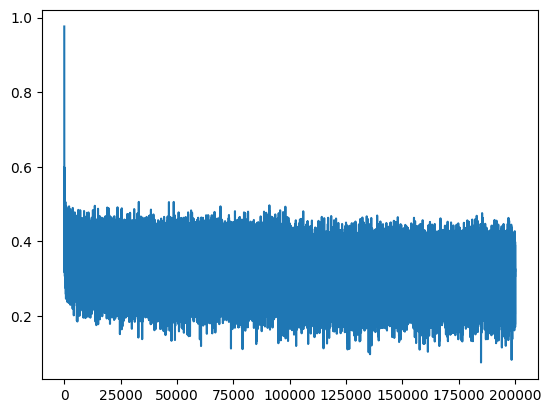

In [33]:
plt.plot(loss_at_i)

In [34]:
# layers in non training mode to evaluate. required in batch norm
for layer in layers:
  layer.training = False

In [35]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  emb = C[x]
  emb = emb.view(emb.shape[0], -1)
  for layer in layers:
    emb = layer(emb)
  loss = F.cross_entropy(emb, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0493836402893066
val 2.114321231842041


In [36]:
# sample from the model

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    emb = emb.view(emb.shape[0], -1)
    for layer in layers:
      emb = layer(emb)
    logits = emb
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

maurie.
rosianna.
tita.
soralyn.
abnuchkinn.
kaila.
selyn.
heon.
ala.
raiahney.
elle.
sando.
zhy.
masar.
kaysha.
brady.
able.
graceome.
erotorianell.
candrix.


In [38]:
# referesher in view
# torch.arange(10)
# torch.arange(10).view(5, 2)
torch.arange(10).view(5, -1) # torch will calculate what the other number in place of -1

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

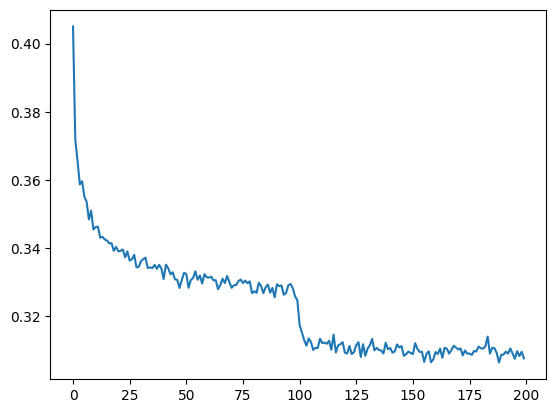

In [40]:
# make a better graph
# torch.tensor(loss_at_i).view(-1, 1000).mean(1).shape
plt.plot(torch.tensor(loss_at_i).view(-1, 1000).mean(1))

In [43]:
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

class Flatten:

  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out

  def parameters(self):
    return []

In [45]:
n_embed = 10
n_hidden = 200
vocab_size = len(itos)

# C = torch.randn((vocab_size, n_embed)) # instead of this we now have Embedding layer
layers = [
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer is less confident

parameters = [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

12097


In [47]:
max_steps = 200_000
batch_size = 32
loss_at_i = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  # emb = C[Xb]
  # emb = emb.view(emb.shape[0], -1) # dont need these two now. part of layer
  x = Xb
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  loss_at_i.append(loss.log10().item())

      0/ 200000: 3.3092
  10000/ 200000: 1.6836
  20000/ 200000: 1.7150
  30000/ 200000: 2.1240
  40000/ 200000: 2.0604
  50000/ 200000: 2.2046
  60000/ 200000: 2.3882
  70000/ 200000: 1.9053
  80000/ 200000: 1.8545
  90000/ 200000: 2.7124
 100000/ 200000: 2.0191
 110000/ 200000: 2.2716
 120000/ 200000: 1.8834
 130000/ 200000: 2.2657
 140000/ 200000: 2.1789
 150000/ 200000: 2.2136
 160000/ 200000: 2.2511
 170000/ 200000: 1.7167
 180000/ 200000: 2.0312
 190000/ 200000: 2.0370


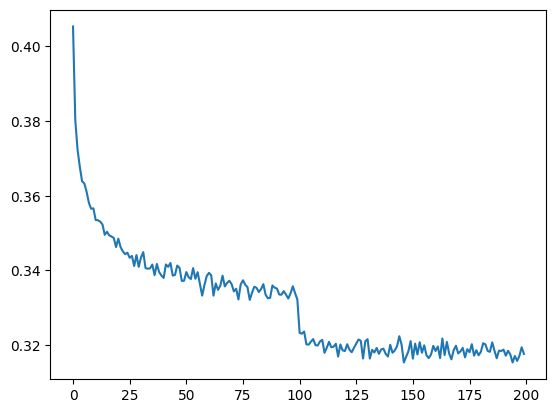

In [48]:
plt.plot(torch.tensor(loss_at_i).view(-1, 1000).mean(1))

In [50]:
# we can simplify it even more to not have a naked list. We can do something like Sequential
# we are basically trying to mimic what torch has and do it ourselved
# https://pytorch.org/docs/stable/nn.html#containers

class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [60]:
n_embed = 10
n_hidden = 200
vocab_size = len(itos)

# C = torch.randn((vocab_size, n_embed)) # instead of this we now have Embedding layer
model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer is less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

24097


In [61]:
max_steps = 200_000
batch_size = 32
loss_at_i = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  # emb = C[Xb]
  # emb = emb.view(emb.shape[0], -1) # dont need these two now. part of layer
  # x = Xb
  # for layer in layers:
  #   x = layer(x)
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  loss_at_i.append(loss.log10().item())

      0/ 200000: 3.3270
  10000/ 200000: 2.3185
  20000/ 200000: 1.9772
  30000/ 200000: 1.8233
  40000/ 200000: 2.2998
  50000/ 200000: 1.9965
  60000/ 200000: 2.5866
  70000/ 200000: 1.9132
  80000/ 200000: 2.3008
  90000/ 200000: 1.7143
 100000/ 200000: 2.2452
 110000/ 200000: 2.1051
 120000/ 200000: 2.0149
 130000/ 200000: 1.7232
 140000/ 200000: 1.8108
 150000/ 200000: 2.3331
 160000/ 200000: 1.9736
 170000/ 200000: 2.3632
 180000/ 200000: 1.9604
 190000/ 200000: 1.5496


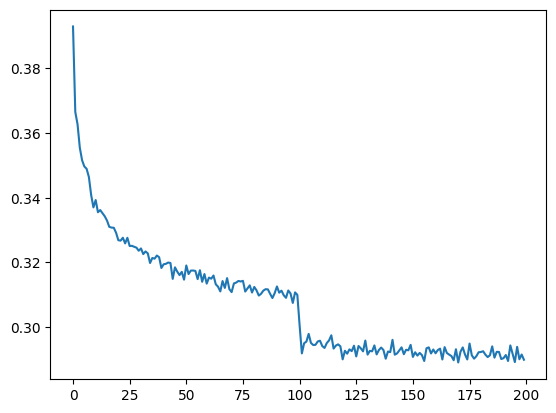

In [62]:
plt.plot(torch.tensor(loss_at_i).view(-1, 1000).mean(1))

In [63]:
for layer in model.layers: # this needs to go as well
  layer.training = False

@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  # emb = C[x]
  # emb = emb.view(emb.shape[0], -1)
  # for layer in layers:
  #   emb = layer(emb)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9275084733963013
val 2.031700372695923


In [57]:
for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    # emb = C[torch.tensor([context])]
    # emb = emb.view(emb.shape[0], -1)
    # for layer in layers:
    #   emb = layer(emb)
    # logits = emb
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

tamonna.
rimi.
arvi.
fion.
chistia.
jazari.
sumatt.
toriell.
kylani.
vion.
zian.
te.
nohdangela.
makeenayannikusa.
les.
gayalee.
ray.
azia.
zayan.
mosephaciola.


We still are not overfitting based on evaluated numbers.

We can do better by increasing the size of neural network and making everything bigger and deeper.
We currently are doing model as represented in https://papers.nips.cc/paper_files/paper/2000/file/728f206c2a01bf572b5940d7d9a8fa4c-Paper.pdf page4.

We are taking some number of characters and going into a single hidden layer and then going into the prediction of next character.

the problem here is that we don't have a naive way of making this bigger in a productive way. We could use our building blocks to introduce additional layers and make it deeper. It will still remain the case that we are crushing all of the characters into a single layer all the way at beginning and even if we make this bigger layer and add neurons it is still kind of like silly to squash all that information so fast in a single step.

We would like our network to look like wavent. https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/
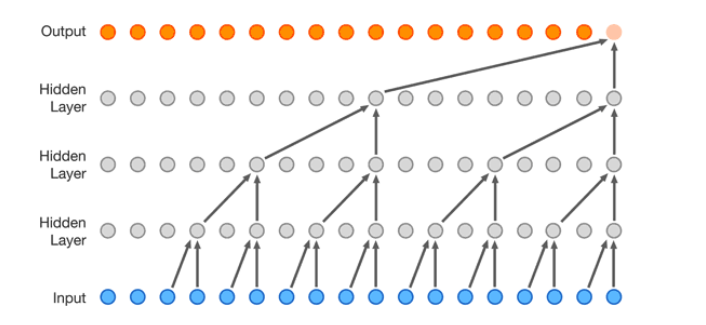

You see in the wavenet when we are trying to make the prediction for next layer in the sequence; it is a function of the previous character that feed in but not all of these characters are just crushed to a single layer. They are crushed slowly.

In particular we take characters and we fue them into sort of bigram representation and we do that for all character consecutively. We then take bigrams and fuse those into four character level chunks. We keep doing this in tree like hierarchical manner.

So basically we fuse the information from previous context slowly into the network as it gets deep.

In [64]:
# from here go back and try with block_size 8

In [67]:
# let us evaluate what is happening

# take four examples at random
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape) # sample size and block size
Xb

torch.Size([4, 9])


tensor([[ 0,  0,  0,  0,  0,  1, 20, 26,  5],
        [ 0,  0,  0,  0,  0,  1, 14,  7,  5],
        [ 0,  0,  0,  2, 18,  9, 20, 20,  1],
        [ 0,  0,  0, 19,  8, 21, 12,  1, 13]])

In [68]:
# first layer is embedding layer
model.layers[0].out.shape # embedding layer

# our embedding table has for each character a 10 dimensional vector that we are trying to learn.
# what embedding layer does here is; it plucks out the embedding vector for each one fo these integers
# and organizes it in 4 * 9 * 10 tensor.

torch.Size([4, 9, 10])

In [69]:
model.layers[1].out.shape # flatten layer

# what it effectively does is that all 10 dimensional embedding for al these 9 ccharcter just end up being stretched out into a long row.
# basically concatenation

torch.Size([4, 90])

In [70]:
model.layers[2].out.shape # linear layer

torch.Size([4, 200])

Let us look at the linear layer in the forward pass.
Effectively in terms of shape looks like below.
Basically a 4 * 80 input comes into input layer; get multiplied by 80 * 200 matrix inside and added with some bias. The shape is 4 * 200

Torch's '@' operation is very powerful. You can give it higher dimensional matrixes (within rule) and it will be all right.

this is because the multiplication work on last dimension and dimension before it in the input tensor are left unchanged.

Dimension on the left are just treated as batch dimension and we can have multiple batch dimensions.

We can use this fact in our network now.

Remember we have this `n` character coming in and we do not want to flatten them out into large 1d tensor.

Instead we want to group these

`(1, 2), (3, 4), (5, 6), (7, 8)`

```python
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape
```

20 in this case is two chars each of 10 dimension. so we need to change the flatten layer so it does not outpu _4 * 80_ but outputs `4 * 4 * 20`

We will have to change linear layer as well to how much input it expects.

In [75]:
# (torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
# (torch.randn(4, 5, 80) @ torch.randn(80, 200) + torch.randn(200)).shape
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [81]:
e = torch.randn(4, 8, 10) # goals: want this to be (4, 4, 20) where consecutive 10-d vectors gets concatenated
# e.view(4, -1).shape # this is happening currently

In [82]:
# python way of getting all even/odd parts
list(range(10))[::2]
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [84]:
torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape # grabbing even and odd parts and then concatenating

torch.Size([4, 4, 20])

In [86]:
# we can also do
e.view(4, 4, 20).shape

torch.Size([4, 4, 20])

In [88]:
explicit = torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2)
implicit = e.view(4, 4, 20)
# explicit == implicit
(explicit == implicit).all()

tensor(True)

In [90]:
class FlattenConsecutive:

  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1) # https://pytorch.org/docs/main/generated/torch.squeeze.html
    self.out = x
    return self.out

  def parameters(self):
    return []

In [101]:
n_embed = 10
# n_hidden = 200
n_hidden = 68 # this helps us keep the number of parameters same as previous model for fair comparision
vocab_size = len(itos)

# C = torch.randn((vocab_size, n_embed)) # instead of this we now have Embedding layer
# model = Sequential([
#     Embedding(vocab_size, n_embed),
#     FlattenConsecutive(block_size), # this will replicate the current behaviour
#     Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size),
# ])

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer is less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

22397


In [102]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape) # sample size and block size
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 14,  1, 19,  9,  1,  8],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0, 14,  9, 14],
        [ 0,  0,  0,  0,  0,  0, 11,  1]])

In [104]:
for layer in model.layers:
  print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [105]:
max_steps = 200_000
batch_size = 32
loss_at_i = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  loss_at_i.append(loss.log10().item())

      0/ 200000: 3.5593
  10000/ 200000: 2.2404
  20000/ 200000: 2.2285
  30000/ 200000: 2.0989
  40000/ 200000: 2.1360
  50000/ 200000: 1.9549
  60000/ 200000: 2.2716
  70000/ 200000: 2.2079
  80000/ 200000: 2.0955
  90000/ 200000: 2.0917
 100000/ 200000: 1.9160
 110000/ 200000: 2.1351
 120000/ 200000: 2.0349
 130000/ 200000: 1.9514
 140000/ 200000: 1.5495
 150000/ 200000: 1.7090
 160000/ 200000: 1.8804
 170000/ 200000: 2.2339
 180000/ 200000: 2.1941
 190000/ 200000: 2.3983


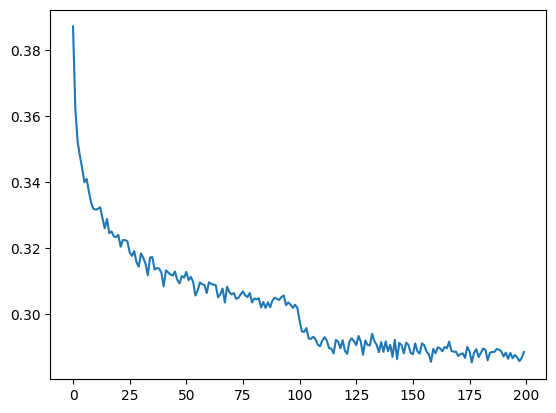

In [106]:
plt.plot(torch.tensor(loss_at_i).view(-1, 1000).mean(1))

In [107]:
for layer in model.layers: # this needs to go as well
  layer.training = False

@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  # emb = C[x]
  # emb = emb.view(emb.shape[0], -1)
  # for layer in layers:
  #   emb = layer(emb)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9228019714355469
val 2.018551826477051


76579
      0/ 200000: 3.4425
  10000/ 200000: 1.6663
  20000/ 200000: 1.6922
  30000/ 200000: 1.9636
  40000/ 200000: 2.1615
  50000/ 200000: 2.0950
  60000/ 200000: 2.0591
  70000/ 200000: 2.2480
  80000/ 200000: 1.8272
  90000/ 200000: 1.8757
 100000/ 200000: 1.7776
 110000/ 200000: 1.9053
 120000/ 200000: 1.7185
 130000/ 200000: 2.1554
 140000/ 200000: 1.6722
 150000/ 200000: 1.7633
 160000/ 200000: 2.1334
 170000/ 200000: 1.8472
 180000/ 200000: 1.7768
 190000/ 200000: 1.7091


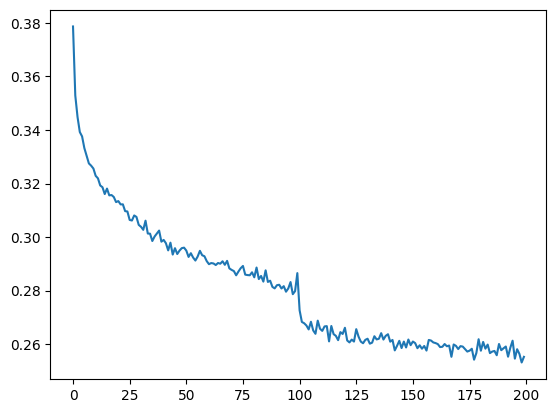

In [108]:
n_embed = 24
n_hidden = 128
vocab_size = len(itos)

model = Sequential([
    Embedding(vocab_size, n_embed),
    FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

with torch.no_grad():
  layers[-1].weight *= 0.1 # last layer is less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

max_steps = 200_000
batch_size = 32
loss_at_i = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  loss_at_i.append(loss.log10().item())

plt.plot(torch.tensor(loss_at_i).view(-1, 1000).mean(1))

In [113]:
for layer in model.layers: # this needs to go as well
  layer.training = False

@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  # emb = C[x]
  # emb = emb.view(emb.shape[0], -1)
  # for layer in layers:
  #   emb = layer(emb)
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train nan
val nan


In [109]:
# why convolutions?

for x, y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '---->', itos[y.item()])

........ ----> l
.......l ----> i
......li ----> n
.....lin ----> d
....lind ----> o
...lindo ----> n
..lindon ----> .
........ ----> l


In [110]:
# forward single example
logits = model(Xtr[[7]])
logits.shape

<ipython-input-30-09735dcd9d03>:37: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  xvar = x.var(dim, keepdim=True) # batch variance


torch.Size([1, 27])

In [111]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

# so basically this "for" loop outside in python
# move to CUDA in kernels.
# it gets hidden in the convolution
# this is efficient because:
# 1. it executes in kernel
# 2. some computations can be re-used

<ipython-input-30-09735dcd9d03>:37: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1823.)
  xvar = x.var(dim, keepdim=True) # batch variance


torch.Size([8, 27])

In [112]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space